<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Physics_Classifying_Gravitational_Waves_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Gravitational waves classification

In this notebook, we attempt to build a neural network to classify gravitational waves and pure noise signals.

Gravitational waves are disturbances in the curvature of spacetime, generated by accelerated masses, that propagate as waves outward from their source at the speed of light. Although they ripple, in real scenario most signals are obtained with noise and so they cannot be visually distinguished from noise signals. The gravitational waves are generated with using the [LALSuite IMRPhenomD generator](https://arxiv.org/pdf/1508.07250.pdf).

The aim of this work is to classify gravitation waves and pure noise signals using 1d convolutional and dense layers.


In [1]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Multiply, Add, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# sklearn

from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# helpers
import urllib.request
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Physics')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Physics/"
files_to_download = ["gravitational_wave_dataset.npy"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

The data is stored in 'Physics/gravitational_wave_dataset.npz', containing 2,000 signals: 1,000 examples of signals and 1,000 examples of pure noise. The signals are 1 second long with a sample rate of 8196.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
grav_wave = np.load(join(data_path, 'Physics/gravitational_wave_dataset.npy'), allow_pickle=True)
```
    
</p>
</details>

In [4]:
grav_wave = np.load(join(data_path, 'Physics/gravitational_wave_dataset.npy'), allow_pickle=True)

In [7]:
def prepare_datset(X, target = 'regression'):
    if target == 'regression':
        x = np.expand_dims(np.sum(np.stack(X[:1000, 2]), axis = -1), axis = -1).astype(np.float32)
        y = np.stack([[w[0] for w in  grav_wave[j, [3, 4]]] for j in np.arange(1000)])
        y = y.reshape(len(x), 2).astype(np.float32)

    elif target == 'classification':
        x = np.expand_dims(np.sum(np.stack(X[:, 1]), axis = -1), axis = -1)
        y = X[:, 0].astype(int)

    return x, y



Prepare a dataset for a classification task using the prepare_dataset function and split it using the train_test_split funtion

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
x, y = prepare_datset(grav_wave, target = 'classification')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)    
```
    
</p>
</details>

In [8]:
x, y = prepare_datset(grav_wave, target = 'classification')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (1600, 8192, 1)
y_train shape:  (1600,)
x_test shape:  (400, 8192, 1)
y_test shape:  (400,)


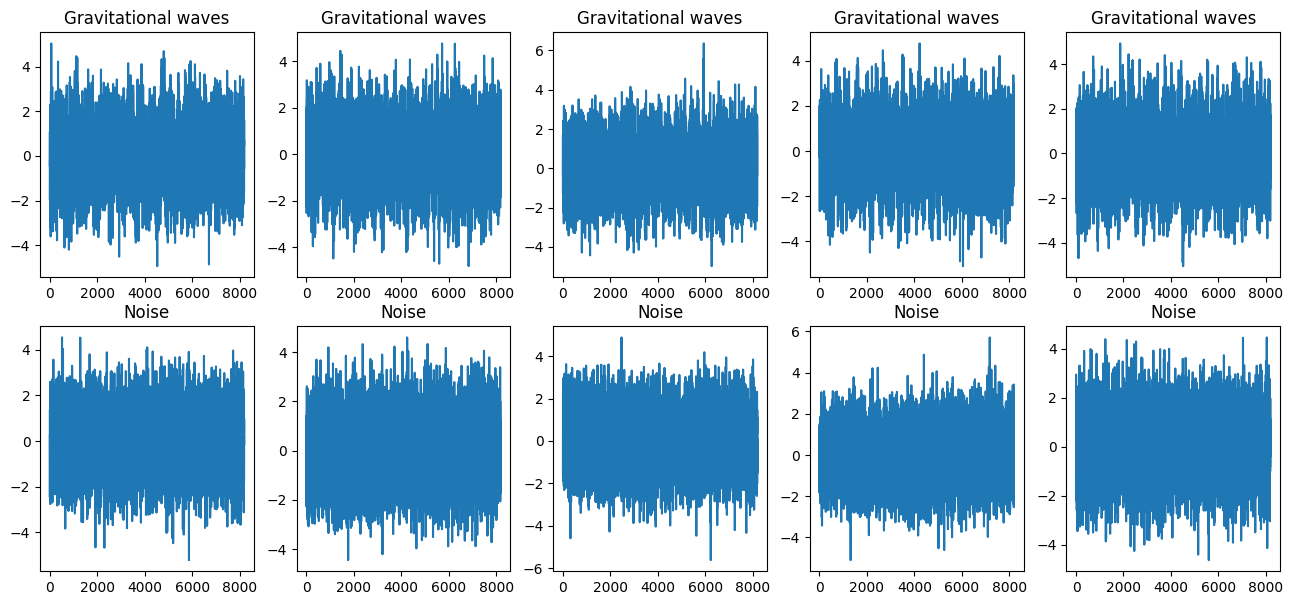

In [9]:
fig, axes = plt.subplots(2, 5, figsize = (16, 7))

for i in range(2):
    sub_idx = np.where(y_train == i)[0]
    for j in range(5):
        axes[i][j].plot(x_train[sub_idx[j]])
        axes[i][j].set_title('Gravitational waves' if i ==0 else 'Noise')

---

# 2. Build the network

We will build a support vector machine (SVM) and a 1D-convolutional neural network to compare their results.



### Support Vector Machine

Use SVM from sklearn library.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# fit linear regression model
model = svm.SVC().fit(x_train.reshape(-1, 8192), y_train)
# make predictions
y_train_pred = model.predict(x_train.reshape(-1, 8192))
y_test_pred = model.predict(x_test.reshape(-1, 8192))
```
    
</p>
</details>

In [10]:
# fit linear regression model
model = svm.SVC().fit(x_train.reshape(-1, 8192), y_train)
# make predictions
y_train_pred = model.predict(x_train.reshape(-1, 8192))
y_test_pred = model.predict(x_test.reshape(-1, 8192))

In [11]:
# compute some fitting error
print('Accuracy on the train set = %f ' % metrics.accuracy_score(y_train, y_train_pred))
print('Accuracy on the test set = %f ' % metrics.accuracy_score(y_test, y_test_pred))

Accuracy on the train set = 1.000000 
Accuracy on the test set = 0.967500 


### Build a Neural Network

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
model = Sequential()
model.add(Input(shape=(x_train.shape[1],1,)))

model.add(Conv1D(filters=16, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=32, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "sigmoid"))        

opt = tf.keras.optimizers.Adam(0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt)



stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min", restore_best_weights=True,patience=5)
history = model.fit(x_train, y_train, epochs=99, batch_size=64,
                             validation_split=0.2,callbacks=[stopper])
```
    
</p>
</details>

In [12]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1],1,)))

model.add(Conv1D(filters=16, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=32, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "sigmoid"))

opt = tf.keras.optimizers.Adam(0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt)



stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min", restore_best_weights=True,patience=5)
history = model.fit(x_train, y_train, epochs=99, batch_size=64,
                             validation_split=0.2,callbacks=[stopper])

Epoch 1/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.8614 - val_loss: 0.6178
Epoch 2/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5806 - val_loss: 0.6246
Epoch 3/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4185 - val_loss: 0.3575
Epoch 4/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2649 - val_loss: 0.2431
Epoch 5/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1483 - val_loss: 0.1692
Epoch 6/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0950 - val_loss: 0.1365
Epoch 7/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0663 - val_loss: 0.1045
Epoch 8/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0405 - val_loss: 0.0876
Epoch 9/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0282 - val_loss: 0.0780
Epoch 10/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0232 - val_loss: 0.0733
Epoch 11/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0164 - val_loss: 0.0666
Epoch 12/99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

---

# 3. Analyse results

### prediction

We used the sigmoid function. Hence, the label will be 1 if the output is greater than 0.5 and 0 otherwise.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

y_train_pred = np.where(y_train_pred>0.5, 1., 0.)
y_test_pred = np.where(y_test_pred>0.5, 1., 0.)
```
    
</p>
</details>

In [13]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

y_train_pred = np.where(y_train_pred>0.5, 1., 0.)
y_test_pred = np.where(y_test_pred>0.5, 1., 0.)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [14]:
# compute some fitting error
print('Accuracy on the train set = %f ' % metrics.accuracy_score(y_train, y_train_pred.reshape(-1)))
print('Accuracy on the test set = %f ' % metrics.accuracy_score(y_test, y_test_pred.reshape(-1)))

Accuracy on the train set = 0.997500 
Accuracy on the test set = 0.987500 


In [15]:
agree_idxs = np.where(y_test == y_test_pred.reshape(-1))[0]
disagree_idxs = np.where(y_test!=y_test_pred.reshape(-1))[0]

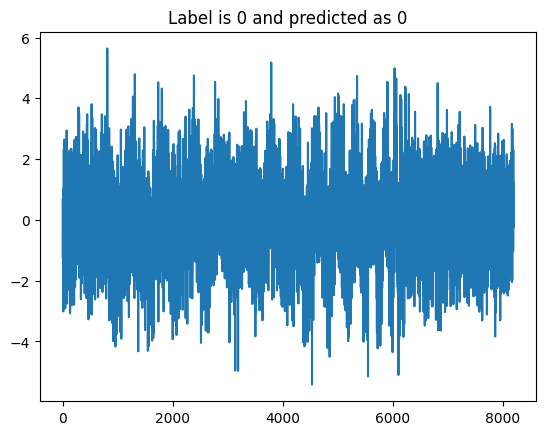

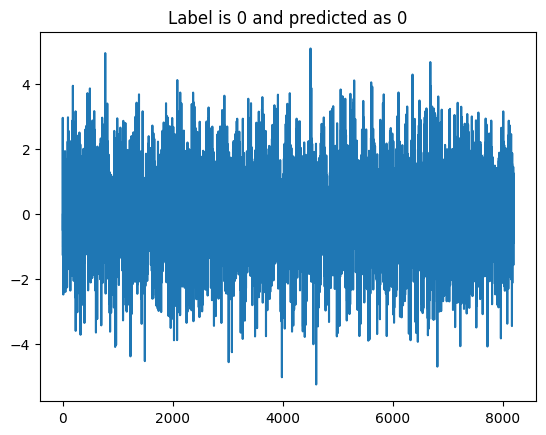

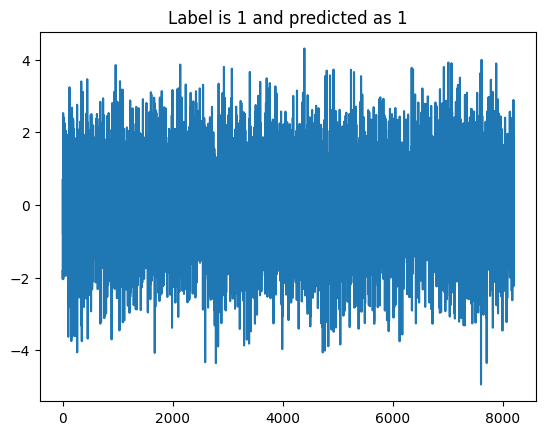

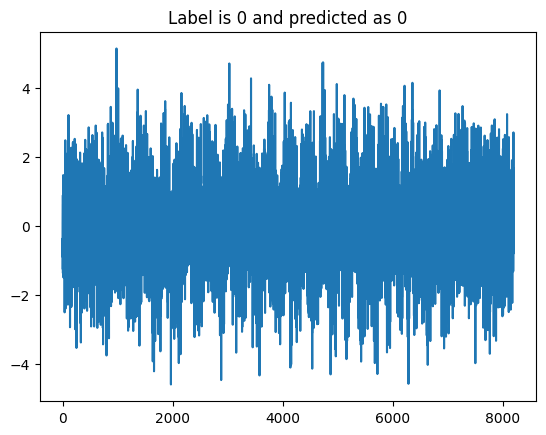

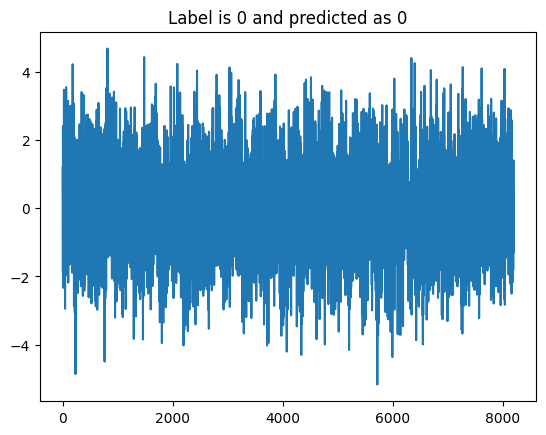

In [16]:
for _ in range(len(disagree_idxs)):
    agree_idx = np.random.choice(len(agree_idxs), 1)[0]
    plt.figure()
    plt.plot(x_test[agree_idx])
    plt.title('Label is {} and predicted as {}'.format(y_test[agree_idx], int(y_test_pred[agree_idx][0])))

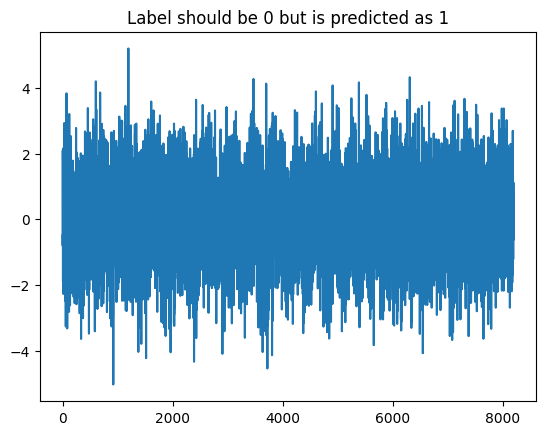

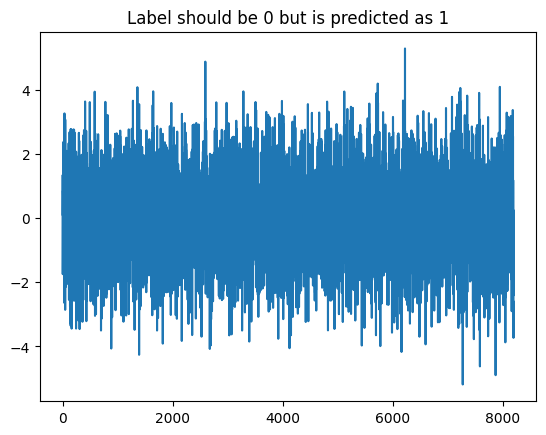

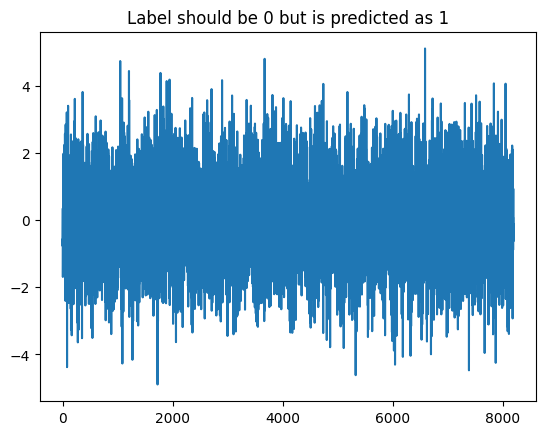

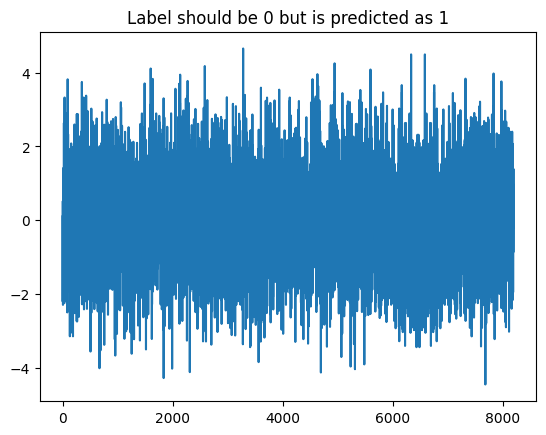

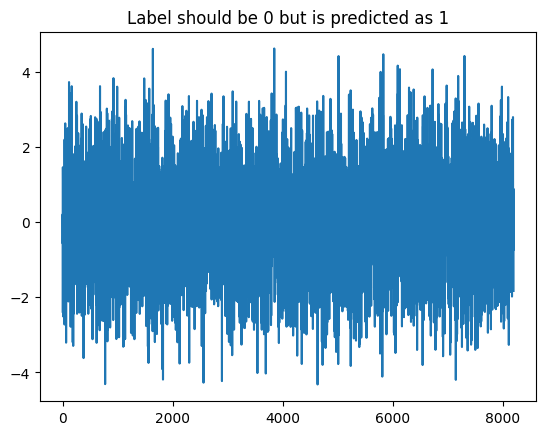

In [17]:
for disagree_idx in disagree_idxs:
    plt.figure()
    plt.plot(x_test[disagree_idx])
    plt.title('Label should be {} but is predicted as {}'.format(y_test[disagree_idx], int(y_test_pred[disagree_idx][0])))

---

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model));
* Change the architeture and activation functions of neural networks to improve the accuracy